In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import r2_score,max_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from statistics import mean
import datetime
from sklearn.svm import SVC

In [2]:
from dateutil import parser

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
from pmdarima.arima import auto_arima

In [6]:
covid_nlv=pd.read_excel(r"C:\Datasets\covid 19\covid_nlv.xlsx")

In [7]:
covid_nlv=covid_nlv.iloc[:,1:]

In [8]:
covid_nlv.set_index('Date',inplace=True)

In [9]:
covid_nlv

,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Date,,,,,,
2020-01-30,1,1,0,0,0,0
2020-01-31,0,1,0,0,0,0
2020-02-01,0,1,0,0,0,0
2020-02-02,1,2,0,0,0,0
2020-02-03,1,3,0,0,0,0
...,...,...,...,...,...,...
2020-06-28,19610,549200,11631,321778,384,16488
2020-06-29,18339,567539,13497,335275,417,16905
2020-06-30,18256,585795,12565,347840,506,17411


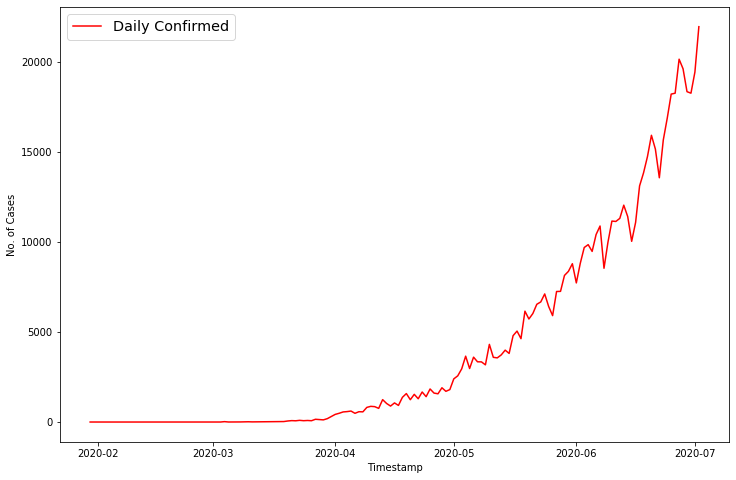

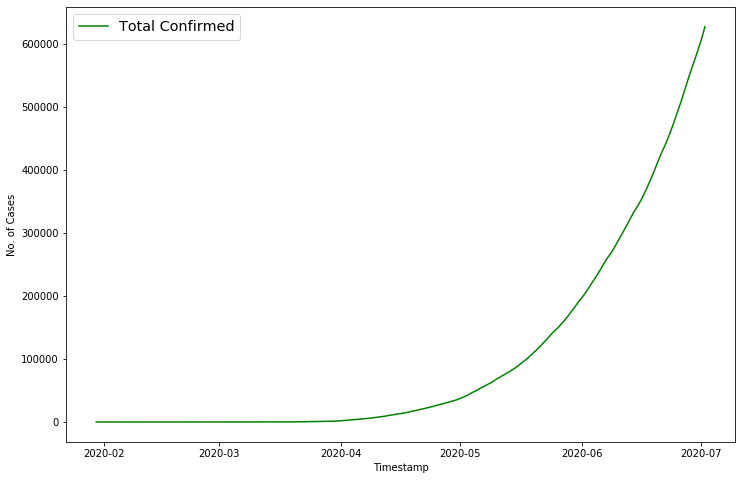

In [70]:
#scatter plot of feature vs target
plt.figure(figsize=[12,8])
plt.plot(covid_nlv['Daily Confirmed'],color='r',label='Daily Confirmed')
plt.legend(loc='best',fontsize='x-large')
plt.xlabel('Timestamp')
plt.ylabel('No. of Cases')
plt.show()
plt.figure(figsize=[12,8])
plt.plot(covid_nlv['Total Confirmed'],color='g',label='Total Confirmed')
plt.legend(loc='best',fontsize='x-large')
plt.xlabel('Timestamp')
plt.ylabel('No. of Cases')
plt.show()

In [11]:
def adf_test(sal):
    result=adfuller(sal)
    label=['ADF test statistic','P-value','Lags used','No. of obs. used']
    for value,label in zip(result,label):
        print(label+' : '+str(value))
    if result[1]<=0.05:
        print("The data is Stationary")
    else:
        print("The data is not Not stationary")

In [12]:
adf_test(covid_nlv['Total Confirmed'])

ADF test statistic : -0.27301056748625874
P-value : 0.929240815863877
Lags used : 14
No. of obs. used : 139
The data is not Not stationary


**Daily Confirmed Cases**

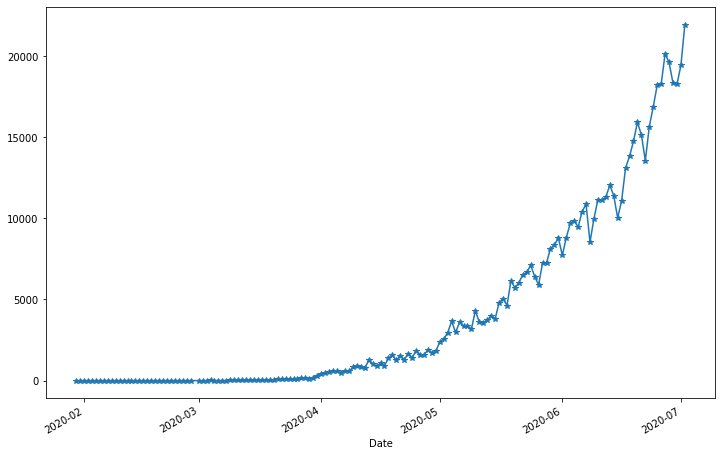

In [71]:
covid_nlv['Daily Confirmed'].plot(figsize=(12,8),marker='*')

The data is not stationary caues there is a visible trend

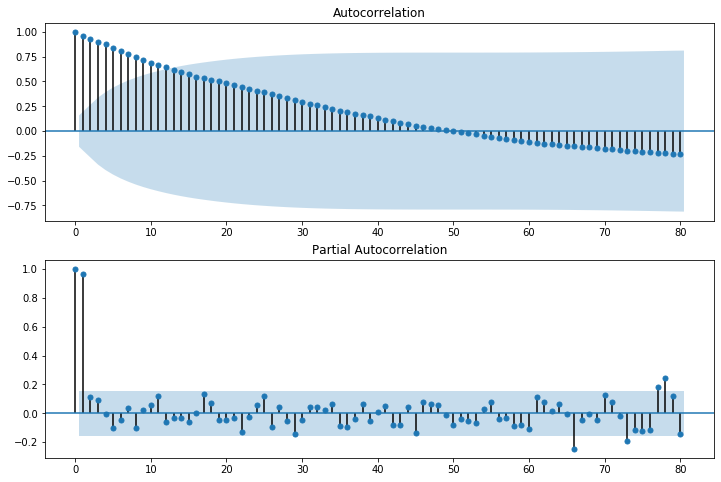

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(covid_nlv['Daily Confirmed'].iloc[0:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(covid_nlv['Daily Confirmed'].iloc[0:],lags=80,ax=ax2)

In [93]:
trend_smooth=covid_nlv['Daily Confirmed'][:130]
train_smooth=covid_nlv['Daily Confirmed'][117:130]#144
test_smooth=covid_nlv['Daily Confirmed'][130:]

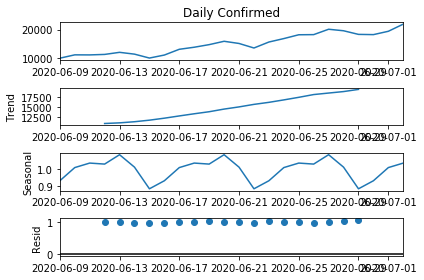

In [94]:
ts_decomp=sm.tsa.seasonal_decompose(test_smooth,model='multiplicative')
ts_decomp.plot()
plt.show()

In [100]:
model_smooth=ExponentialSmoothing(train_smooth,trend='mul',damped=False,seasonal='mul',seasonal_periods=7).fit()
pred=model_smooth.predict(start=test_smooth.index[0],end=test_smooth.index[-1])

C:\Users\taraf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\taraf\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [101]:
covid_nlv['Daily Confirmed MA(5)']=covid_nlv['Daily Confirmed'].rolling(5).mean()

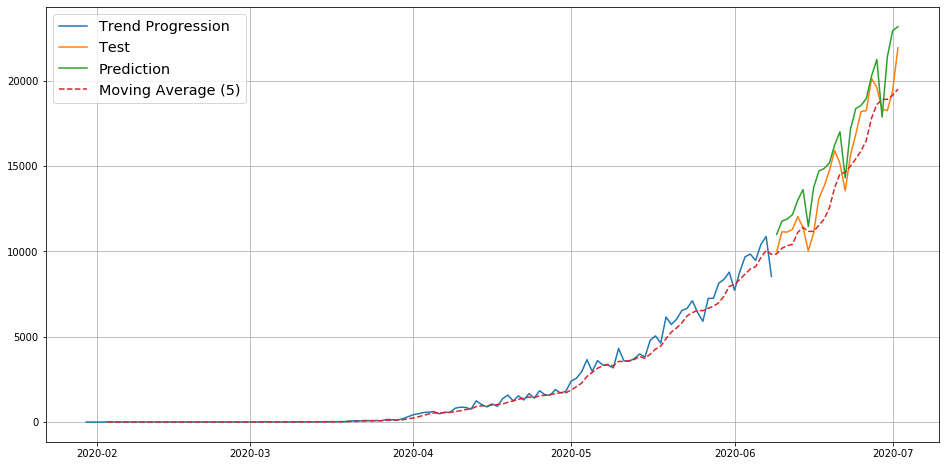

In [102]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(trend_smooth.index,trend_smooth,label='Trend Progression')
plt.plot(test_smooth.index,test_smooth,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(covid_nlv['Daily Confirmed MA(5)'],linestyle='dashed',label='Moving Average (5)')
plt.legend(loc='best',fontsize='x-large')
plt.show()

In [103]:
MSE=mean_squared_error(pred,test_smooth)
MAPE=np.mean(np.abs((pred - test_smooth) /pred)) * 100
MADp=stats.median_absolute_deviation(pred)
MADt=stats.median_absolute_deviation(test_smooth)
print("Mean Sqaured Error",MSE)
print("Mean Absolute Percentage Error",MAPE)
print("Mean Absolute Deviation (pred)",MADp)
print("Mean Absolute Deviation (pred)",MADt)

Mean Sqaured Error 2409845.6356836725
Mean Absolute Percentage Error 7.998019203061897
Mean Absolute Deviation (pred) 4115.4348546358615
Mean Absolute Deviation (pred) 4969.6752


**Total Confirmed Cases**

In [19]:
trend_auto=covid_nlv['Total Confirmed'][:130]
train_auto=covid_nlv['Total Confirmed'][50:130]#144
test_auto=covid_nlv['Total Confirmed'][129:]

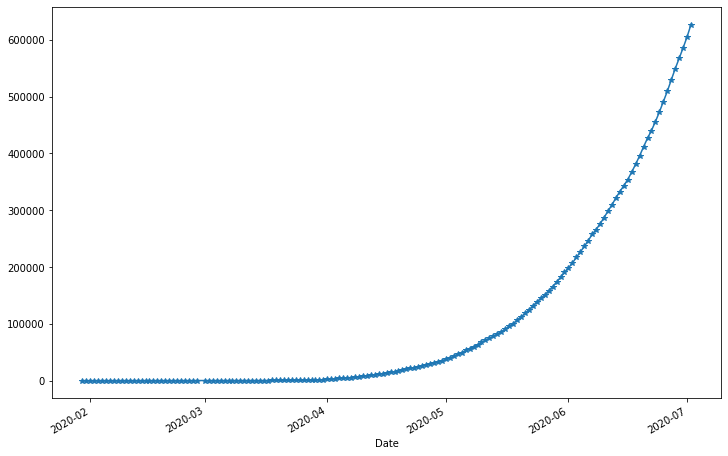

In [72]:
covid_nlv['Total Confirmed'].plot(figsize=(12,8),marker='*')

In [21]:
model_auto=ExponentialSmoothing(train_auto,trend='mul',damped=False).fit()
pred_auto=model_auto.predict(start=test_auto.index[0],end=test_auto.index[-1])

C:\Users\taraf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\taraf\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [22]:
covid_nlv['Total Confirmed MA(5)']=covid_nlv['Total Confirmed'].rolling(5,center=True).mean()

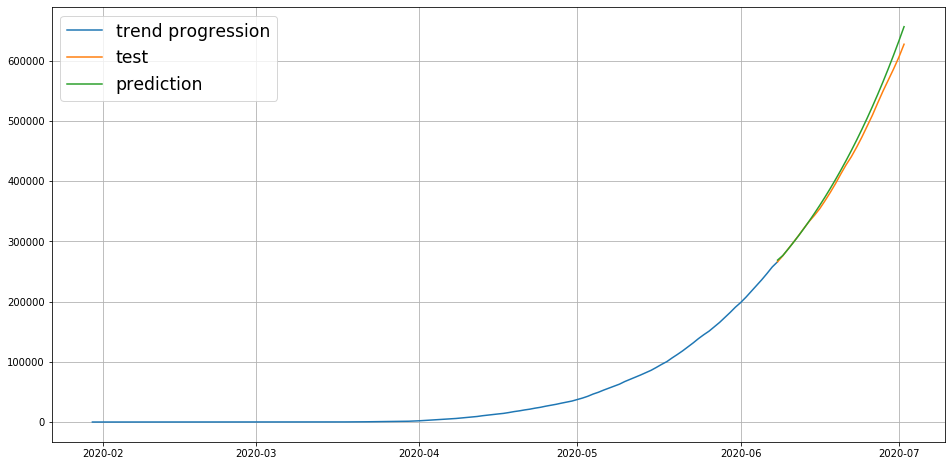

In [23]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(trend_auto.index,trend_auto,label='trend progression')
plt.plot(test_auto.index,test_auto,label='test')
plt.plot(pred_auto.index,pred_auto,label='prediction')
#plt.plot(covid_nlv['Tottal Confirmed MA(5)'],linestyle='dashed',label='Moving Average (5)')
plt.legend(loc='best',fontsize='xx-large')
plt.show()

In [53]:
MSE1=mean_squared_error(pred_auto,test_auto)
MAPE1=np.mean(np.abs((pred_auto - test_auto) /pred_auto)) * 100
MADp1=stats.median_absolute_deviation(pred_auto)
MADt1=stats.median_absolute_deviation(test_auto)
print("Mean Sqaured Error",MSE1)
print("Mean Absolute Percentage Error",MAPE1)
print("Mean Absolute Deviation (pred)",MADp1)
print("Mean Absolute Deviation (pred)",MADt1)

Mean Sqaured Error 157906056.0948036
Mean Absolute Percentage Error 1.8445055461916862
Mean Absolute Deviation (pred) 143390.84950992625
Mean Absolute Deviation (pred) 133604.49899999998


In [52]:
X = covid_nlv['Total Confirmed'].values
window = 2
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)

predicted=1.000000, expected=1.000000
predicted=1.000000, expected=2.000000
predicted=1.000000, expected=3.000000
predicted=2.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.

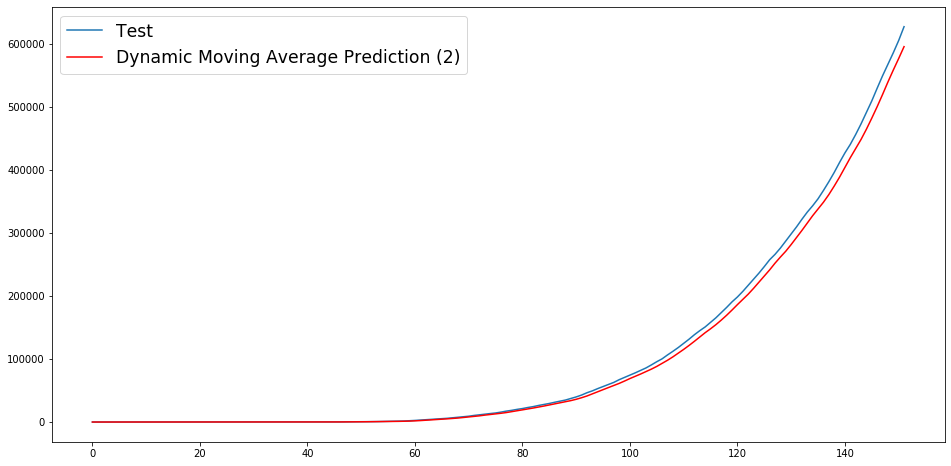

In [66]:
plt.figure(figsize=(16,8))
plt.plot(test,label='Test')
plt.plot(predictions, color='red',label='Dynamic Moving Average Prediction (2)')
plt.legend(loc='best',fontsize='xx-large')
plt.show()